# 2021 Biomedical Data Science Hackathon
### This notebook contains data preparation and prediction processes for our participation in a data science Hackathon

The team is provided with 3 csv files containing training and testing datasets.

\#The dataset is a collection of "unnormalized counts of genes from RNASeq performed on patients"

\#A designed challenge is working with data from an unfamiliar context, and participants (w/ or w/o Biology background) are expected to have limited prior knowledge.  

The goal is to predict the age of a patient from their gene profile.

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [2]:
##load train data
df_expression = pd.read_csv(
    './train_data/train_expression.csv.gz', compression='gzip')

df_labels = pd.read_csv(
    './train_data/train_labels.csv')

In [7]:
#Load prediction data 
df_expression_test = pd.read_csv(
    './test_data/test_expression.csv.gz', compression='gzip')

df_labels_test = pd.read_csv(
    './test_data/test_LABELS.csv')

## Preliminary Planning, Analysis, and Preprocessing


In [5]:
##normalize data (train)
normalized_expression = preprocessing.normalize(df_expression)
df_norm_expression = pd.DataFrame(normalized_expression, columns=df_expression.columns)

In [8]:
##normalize data (test)
normalized_expression_test = preprocessing.normalize(df_expression_test)
df_norm_expression_test = pd.DataFrame(normalized_expression_test, columns=df_expression.columns)

In [1]:
##This cell of code pulls a small sample of the data for planning

# ##pull 5 columns from expression
# rand_five_feat_names = df_norm_expression.columns[:5]
# rand_five_feats = df_norm_expression[rand_five_feat_names]

# ##generate 30 row index for analysis
# list_rand_rows_nums = rnd.choices(range(len(df_labels)), k=50)
# len(list_rand_rows_nums)

##select rows from labels (only age) & expression tables

# df_feats_w_age = rand_five_feats.copy()
# df_feats_w_age['age'] = df_labels['age']

# df_feats_w_age_sample = df_feats_w_age.iloc[list_rand_rows_nums]
# df_feats_w_age_sample.describe()

# df_feats_w_age_sample.corr()

In [9]:
df_feats_w_age_sample = df_norm_expression.copy()
df_feats_w_age_sample['age'] = df_labels['age']

In [10]:
##split data
X = df_norm_expression
y = df_labels['age']

#skip to pickle read for selected 5k features


In [11]:
##variance
# df_feats_w_age_sample.var()
std_calc = X.std()

In [86]:
std_calc.describe()

count    5.293500e+04
mean     4.062865e-04
std      2.422413e-03
min      1.134322e-08
25%      5.184202e-07
50%      5.502466e-06
75%      1.420882e-04
max      1.318569e-01
dtype: float64

15


(array([26003.,  3229.,  1822.,  1146.,   901.,   717.,   593.,   530.,
          490.,   390.,   375.,   326.,   299.,   282.]),
 array([0.0e+00, 5.0e-06, 1.0e-05, 1.5e-05, 2.0e-05, 2.5e-05, 3.0e-05,
        3.5e-05, 4.0e-05, 4.5e-05, 5.0e-05, 5.5e-05, 6.0e-05, 6.5e-05,
        7.0e-05]),
 <BarContainer object of 14 artists>)

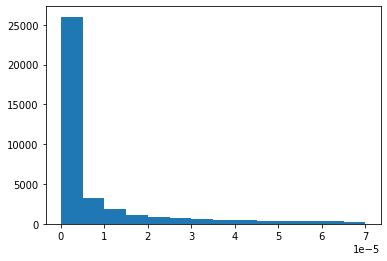

In [99]:
bin_a=[0,0.000005,0.000010,0.000015,0.00002,0.000025, 0.000030,
    0.000035, 0.000040, 0.000045,0.000050, 0.000055, 0.000060, 0.000065
    ,0.000070  ]
print(len(bin_a))
plt.hist(std_calc,bins=bin_a)


<AxesSubplot:>

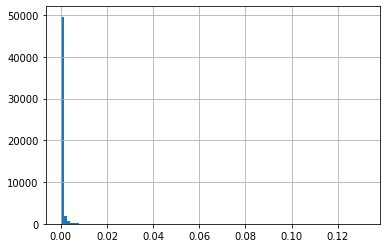

In [9]:
std_calc.hist(bins=10)

##This reveals that nearly 50k features have very weak variance, 
# and thereby unlikely to contain vital information for age prediction

In [13]:
##feature selection: SelectKBest
# Selects the top 25% scoring features -- about 13k features 
k = int(X.shape[1] * 0.25)
selector = SelectKBest(mutual_info_regression, k = k)
selector.fit(X, y)

SelectKBest(k=13233,
            score_func=<function mutual_info_regression at 0x000002A31DE09F70>)

In [14]:
#generate the names of the remaining features 
kbest_support = X.columns[selector.get_support()]
kbest_support

Index(['ENSG00000000005.5', 'ENSG00000000419.12', 'ENSG00000000457.13',
       'ENSG00000000460.16', 'ENSG00000000938.12', 'ENSG00000000971.15',
       'ENSG00000001167.14', 'ENSG00000001461.16', 'ENSG00000001626.14',
       'ENSG00000001630.15',
       ...
       'ENSG00000283602.1', 'ENSG00000283607.1', 'ENSG00000283620.1',
       'ENSG00000283633.1', 'ENSG00000283647.1', 'ENSG00000283657.1',
       'ENSG00000283662.1', 'ENSG00000283683.1', 'ENSG00000283684.1',
       'ENSG00000283697.1'],
      dtype='object', length=13233)

In [15]:
##bivariate correlation between age and 25% percentile features
df_kbest_feats = df_feats_w_age_sample[kbest_support]
df_age = df_labels['age']

pairwise_corr = df_kbest_feats.corrwith(df_age, axis=0, drop=False, method='pearson')
pairwise_corr.describe()
#pairwise_corr

##This reveals - to our dismay - that there's the no statistically significant 
# correlation between many features and age of the patient
# Though it allow us to further reduce the dimentionality of the features 
##This also rule out linear regression as a potential prediction method

count    13233.000000
mean         0.081787
std          0.140539
min         -0.317465
25%         -0.053000
50%          0.138972
75%          0.203979
max          0.306376
dtype: float64

In [14]:
##removing features with less than +- 0.2 correlation with age
# This leaves us with 4 thousand features, which is manageable for some learning attempts
pairwise_corr_filtered = pairwise_corr.loc[abs(pairwise_corr) >= 0.2]
pairwise_corr_filtered

ENSG00000000457.13    0.213035
ENSG00000001461.16    0.221449
ENSG00000004059.10    0.209159
ENSG00000004142.11    0.204998
ENSG00000004478.7     0.250613
                        ...   
ENSG00000283377.1    -0.226683
ENSG00000283390.1     0.233593
ENSG00000283453.1     0.205079
ENSG00000283547.1    -0.201583
ENSG00000283620.1     0.225028
Length: 3873, dtype: float64

In [17]:
##persist the df (the remaining features)
# X_filtered = X[pairwise_corr_filtered.index]
# X_filtered.to_pickle('./X_filtered.pickle')

(965, 3873)


This is the 5k selected pickle

In [9]:
X_filtered = pd.read_pickle('./X_filtered4K.pickle')
print(X_filtered.shape)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

(965, 3873)


In [10]:
##Performing a cartesian product correlation calculation
# The goal is to reveal features that may be strongly correlated with themselves
# and allow us to reduce the features further
filtered_corr = X_filtered.corr(method='pearson')

In [11]:
##removing value 1.0 from the df, as they are the correlation with self
# which is just the diagonal line of the df
filtered_corr_rm_diag = filtered_corr.copy()
for i in range(len(filtered_corr)):
    filtered_corr_rm_diag.iloc[i,i] = None
    
#filtered_corr_rm_diag

,ENSG00000000457.13,ENSG00000001461.16,ENSG00000004059.10,ENSG00000004142.11,ENSG00000004478.7,ENSG00000004779.9,ENSG00000004838.13,ENSG00000005022.5,ENSG00000005156.11,ENSG00000005175.9,...,ENSG00000283174.1,ENSG00000283220.1,ENSG00000283266.1,ENSG00000283368.1,ENSG00000283371.1,ENSG00000283377.1,ENSG00000283390.1,ENSG00000283453.1,ENSG00000283547.1,ENSG00000283620.1
ENSG00000000457.13,NaN,0.629971,0.586050,0.583838,0.560616,0.616913,0.548981,0.579765,0.684301,0.792684,...,-0.263991,0.701752,0.677614,-0.281305,0.757238,-0.371873,0.568959,0.626789,-0.256472,0.698049
ENSG00000001461.16,0.629971,NaN,0.427006,0.504683,0.566244,0.494109,0.436020,0.505156,0.586107,0.662638,...,-0.246419,0.493919,0.658826,-0.288485,0.617767,-0.361990,0.441263,0.619072,-0.248308,0.623120
ENSG00000004059.10,0.586050,0.427006,NaN,0.606935,0.550115,0.777183,0.521925,0.694310,0.515079,0.580500,...,-0.288018,0.685924,0.423980,-0.309645,0.551801,-0.374544,0.786922,0.581512,-0.311487,0.692398
ENSG00000004142.11,0.583838,0.504683,0.606935,NaN,0.641047,0.686901,0.398832,0.652106,0.627791,0.684452,...,-0.229287,0.620567,0.600116,-0.325126,0.533264,-0.340473,0.593315,0.586837,-0.259930,0.664424
ENSG00000004478.7,0.560616,0.566244,0.550115,0.641047,NaN,0.670017,0.506098,0.592668,0.598098,0.699216,...,-0.277383,0.596275,0.615966,-0.400211,0.580040,-0.398938,0.607747,0.606322,-0.307557,0.698339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000283377.1,-0.371873,-0.361990,-0.374544,-0.340473,-0.398938,-0.386857,-0.299730,-0.378911,-0.355282,-0.401772,...,0.247485,-0.378150,-0.388723,0.314276,-0.395259,NaN,-0.415054,-0.418771,0.630886,-0.405978
ENSG00000283390.1,0.568959,0.441263,0.786922,0.593315,0.607747,0.770991,0.610873,0.607880,0.503328,0.555824,...,-0.296566,0.700459,0.450727,-0.462987,0.590088,-0.415054,NaN,0.538731,-0.342924,0.684172
ENSG00000283453.1,0.626789,0.619072,0.581512,0.586837,0.606322,0.614263,0.351811,0.737292,0.649834,0.752840,...,-0.285854,0.537987,0.718616,-0.465573,0.606439,-0.418771,0.538731,NaN,-0.313098,0.693215
ENSG00000283547.1,-0.256472,-0.248308,-0.311487,-0.259930,-0.307557,-0.309210,-0.243198,-0.316987,-0.237279,-0.293809,...,0.142514,-0.295821,-0.241810,0.256793,-0.316983,0.630886,-0.342924,-0.313098,NaN,-0.332379


In [15]:
## We expect *many* clusters of inter-correlated features from this basic report
#  A way to mentally visualize them is to consider them as nodes of a graph, 
#  where an edge exist between two nodes when their correlation is > +- .8

## At this point we decide to attempt some learning models before further 
#  reducing the features. 
filtered_corr_rm_diag.describe()

,ENSG00000000457.13,ENSG00000001461.16,ENSG00000004059.10,ENSG00000004142.11,ENSG00000004478.7,ENSG00000004779.9,ENSG00000004838.13,ENSG00000005022.5,ENSG00000005156.11,ENSG00000005175.9,...,ENSG00000283174.1,ENSG00000283220.1,ENSG00000283266.1,ENSG00000283368.1,ENSG00000283371.1,ENSG00000283377.1,ENSG00000283390.1,ENSG00000283453.1,ENSG00000283547.1,ENSG00000283620.1
count,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,...,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000
mean,0.577464,0.517657,0.527645,0.530568,0.543261,0.574426,0.430566,0.559998,0.543847,0.633920,...,-0.238837,0.545762,0.583129,-0.329799,0.567040,-0.336920,0.529082,0.592693,-0.254591,0.607049
std,0.256664,0.240921,0.256842,0.225744,0.251979,0.253181,0.208610,0.254594,0.245249,0.282835,...,0.131411,0.248949,0.269992,0.212490,0.262085,0.199685,0.271325,0.283170,0.157045,0.272535
min,-0.560534,-0.528495,-0.603606,-0.529907,-0.589222,-0.603262,-0.454203,-0.627079,-0.520204,-0.607611,...,-0.365180,-0.573070,-0.583272,-0.560884,-0.563958,-0.492855,-0.634350,-0.644049,-0.390682,-0.630077
25%,0.574681,0.504684,0.490520,0.535758,0.556207,0.562435,0.405463,0.546069,0.541198,0.620609,...,-0.293321,0.546013,0.550681,-0.441389,0.562874,-0.416813,0.486969,0.566295,-0.322811,0.620636
50%,0.644750,0.583276,0.581144,0.590960,0.609373,0.635370,0.471776,0.627049,0.611870,0.713521,...,-0.271753,0.605190,0.652887,-0.371478,0.633511,-0.385232,0.579154,0.667400,-0.292367,0.677117
75%,0.695956,0.639454,0.664639,0.631819,0.650543,0.692152,0.535769,0.687093,0.659959,0.772971,...,-0.246041,0.655525,0.729485,-0.303292,0.687999,-0.351887,0.673142,0.742010,-0.257142,0.722800
max,0.854063,0.775522,0.886404,0.893947,0.970033,0.876643,0.858121,0.960791,0.789452,0.900455,...,0.774902,0.998809,0.964026,0.996901,0.856796,0.734694,0.895916,0.886999,0.631837,0.987916


In [11]:
filtered_corr_rm_diag.iloc[-1,:].describe()

count    3872.000000
mean        0.607049
std         0.272535
min        -0.630077
25%         0.620636
50%         0.677117
75%         0.722800
max         0.987916
Name: ENSG00000283620.1, dtype: float64

In [12]:
##remove all values where abs(correlation) < 0.8, this effectively becomes a graph now
corr_graph = filtered_corr_rm_diag.copy()
for col in corr_graph.columns:
    corr_graph[col].loc[corr_graph[col] < 0.8] = None

In [13]:
##persist
#corr_graph.to_pickle('./corr_graph.pickle')

In [16]:
corr_graph = pd.read_pickle('./corr_graph.pickle')
corr_graph_describe = corr_graph.describe()
corr_graph.shape

(3873, 3873)

In [23]:
##aggresive pruning, reduce every cluster to a single feature
#The justification is primarily the very small pool of training data
#which is only 1000. At this step the features are reduced to 840, which almost certainly
#is still too much dimension to be reasonably predicted from 1k samples.

#The resulting features appears to have lost large portion of informtaion
#This indicates 1)There are significant information within the inter-correlated clusters
#               2)Some of the independent features may have little mutual information with age

corr_graph_pruned = corr_graph.copy()
corr_graph_val_count = corr_graph_pruned.count()

for feat_name in corr_graph_pruned.index:
    ##if has any link, remove this feature
    if(corr_graph_val_count.loc[feat_name] >= 1):
        corr_graph_pruned.drop(index=feat_name, columns=feat_name, inplace=True)
        corr_graph_val_count = corr_graph_pruned.count()

corr_graph_pruned.shape


(840, 840)

In [29]:
features_to_keep = corr_graph_pruned.index
X_filtered_840 = X[features_to_keep]


In [51]:
#corr_graph_pruned.to_pickle('./corr_graph_pruned.pickle')
X_filtered_840.to_pickle('./X_filtered_840_noCluster.pickle')


In [47]:
corr_graph_counts = corr_graph.count()
#corr_graph_counts[corr_graph_counts == 1]

In [49]:
#Conservative prunning, just removing the leaves...this ends up only taking out less than 200 features
#skip this
corr_graph_pruned = corr_graph.copy()

for feat_name in corr_graph_counts[corr_graph_counts == 1].index:
    corr_graph_pruned_counts = corr_graph_pruned.count()
    
    if corr_graph_pruned_counts[feat_name] == 0:
        # pair already removed
        continue
    
    corr_graph_pruned.drop(index=feat_name, columns=feat_name, inplace=True)
    
#corr_graph_pruned

In [52]:
features_to_keep = corr_graph_pruned.index
X_filtered_3698_leavesPruned = X[features_to_keep]
X_filtered_3698_leavesPruned.to_pickle('./X_filtered_3698_leavesPruned.pickle')


## Learning Model Training

Ignore the next 2 cells

In [20]:
##train: LinearRegression
# This is an attempt made after reducing features down to 14k
# Largely a mental milestone & an indicator of works needed ahead

#reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train, y_train))
print(reg.coef_)
print(reg.intercept_)


1.0
[ 3.43564063e+03  1.87563174e+03 -3.01708875e+03 ... -2.44663385e+00
 -5.27471495e+01  2.04459063e+02]
50.50887375385108


In [21]:
##test
y_pred = reg.predict(X_test)
r2_score(y_test, y_pred)

-21.405575387473107

Neural Network trial/error models

In [75]:
X_filtered = pd.read_pickle('./X_filtered4K.pickle')
print(X_filtered.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.1)


(965, 3873)


In [76]:
##train: Neural Network
# pyramid architecture
t_layers = (300, 200, 100)
regr = MLPRegressor(random_state=1, hidden_layer_sizes=t_layers, max_iter=10000).fit(X_train, y_train)
regr.score(X_test, y_test)


0.07859478461895009

In [77]:
##train: Neural Network
# box architecture
t_layers_box = (100, 100, 100)
regr_box = MLPRegressor(random_state=1, hidden_layer_sizes=t_layers_box, max_iter=10000).fit(X_train, y_train)
regr_box.score(X_test, y_test)


0.10394559820215887

In [17]:
scores = []
scores_box = []

k = 10

for n in range(k):
    X_filtered = pd.read_pickle('./X_filtered_840_noCluster.pickle')
    print(X_filtered.shape)
    X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.1)

    t_layers = (300, 200, 100)
    regr = MLPRegressor(random_state=1, hidden_layer_sizes=t_layers,
                        max_iter=8000).fit(X_train, y_train)
    regr.score(X_test, y_test)

    t_layers_box = (100, 100, 100)
    regr_box = MLPRegressor(
        random_state=1, hidden_layer_sizes=t_layers_box, max_iter=8000).fit(X_train, y_train)
    regr_box.score(X_test, y_test)

    scores.append(regr.score(X_test, y_test))
    scores_box.append(regr_box.score(X_test, y_test))


(965, 840)
(965, 840)
(965, 840)
(965, 840)
(965, 840)
(965, 840)
(965, 840)
(965, 840)
(965, 840)
(965, 840)


In [18]:
print(sum(scores)/k)
print(sum(scores_box)/k)


#840


0.029373455259657965
-0.003927429998355958


In [24]:
def test_script(X_name, k):

    scores = []
    scores_box = []

    for n in range(k):
        X_filtered = pd.read_pickle(X_name)
        print(X_filtered.shape)
        X_train, X_test, y_train, y_test = train_test_split(
            X_filtered, y, test_size=0.1)

        t_layers = (300, 200, 100)
        regr = MLPRegressor(random_state=1, hidden_layer_sizes=t_layers,
                            max_iter=8000).fit(X_train, y_train)
        regr.score(X_test, y_test)

        t_layers_box = (100, 100, 100)
        regr_box = MLPRegressor(
            random_state=1, hidden_layer_sizes=t_layers_box, max_iter=8000).fit(X_train, y_train)
        regr_box.score(X_test, y_test)

        scores.append(regr.score(X_test, y_test))
        scores_box.append(regr_box.score(X_test, y_test))

    print(sum(scores)/k)
    print(sum(scores_box)/k)


In [25]:
k= 10
test_script('./X_filtered_3698_leavesPruned.pickle', k)
test_script('./X_filtered4K.pickle', k)


(965, 3698)
(965, 3698)
(965, 3698)
(965, 3698)
(965, 3698)
(965, 3698)
(965, 3698)
(965, 3698)
(965, 3698)
(965, 3698)
0.0568147287400966
0.04773837553993476
(965, 3873)
(965, 3873)
(965, 3873)
(965, 3873)
(965, 3873)
(965, 3873)
(965, 3873)
(965, 3873)
(965, 3873)
(965, 3873)
0.11445779451967866
0.08694184992442332


In [44]:
pred = regr.predict(X_test[:100]).round()
actual = y_test[:100].values * 1.
data = {'pred': pred, 'actual': actual}
df_predictions = pd.DataFrame(data=data)
df_predictions['error'] = abs(df_predictions['actual'] - df_predictions['pred'])
#pd.set_option("display.max_rows", None)

#print(df_predictions)
df_predictions.describe()


,pred,actual,error
count,100.000000,100.000000,100.000000
mean,52.780000,56.910000,10.330000
std,10.025805,12.500582,7.192947
min,25.000000,24.000000,0.000000
25%,47.750000,53.500000,4.000000
50%,52.000000,54.000000,8.000000
75%,59.000000,64.000000,17.000000
max,84.000000,90.000000,31.000000


In [24]:
## Keep this cell for reference

##  A more comprehensible representation of the NN's accuracy
## Overall, better than initial expectation. We can predict a patient's age group with reasonable confidence 
## This is encouraging, as the NN has potential to improve from further reduction, noise suppression, etc.
df_predictions.describe()

,pred,actual,error
count,100.000000,100.000000,100.000000
mean,52.620000,54.720000,9.900000
std,11.353618,14.219833,6.849759
min,29.000000,24.000000,0.000000
25%,45.000000,44.000000,5.750000
50%,51.000000,54.000000,9.000000
75%,57.000000,64.000000,13.000000
max,91.000000,90.000000,44.000000


In [26]:
## generate prediction csv
pd.set_option("display.max_rows", 10)

X_test_submission = df_norm_expression_test[X_filtered.columns]
age = regr.predict(X_test_submission)
sample_id = df_labels_test['sample_id']
data = {'age': age, 'sample_id': sample_id}
df_submission = pd.DataFrame(data=data)
print(df_submission)
df_submission.to_csv('./prediction/prediction.csv')

           age sample_id
0    39.051694  12fa2c69
1    43.242780  4d41ce5f
2    49.714699  82f6b2bb
3    59.572582  81161a04
4    49.942939  4370df33
..         ...       ...
960  44.467553  f71936c8
961  50.924034  063448fa
962  40.022617  3dd9a2df
963  42.715296  70120a3f
964  50.423730  b9df2325

[965 rows x 2 columns]


## Scratch notes